In [13]:
import json
import numpy as np
import pandas as pd
import geojson
import plotly.graph_objects as go
import urllib.request
import plotly.express as px
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



# Yonne - concession inhumation

In [14]:
with open('../geojson/communes-89-yonne.geojson') as f:
    var_geo = geojson.load(f)
    
#%matplotlib notebook
pd.options.display.max_columns = 150
pd.options.display.max_rows = 2000


# Insertion du dataset Pricing
price = pd.read_csv("../csv/prices.csv", sep=',', encoding='utf-8')

price['jour'] = pd.to_datetime(price['price creation date'], errors='coerce').dt.strftime('%Y-%m-%d')
price['month'] = pd.to_datetime(price['price creation date'], errors='coerce').dt.strftime('%Y-%m')
price['year'] = pd.to_datetime(price['price creation date'], errors='coerce').dt.strftime('%Y')
price = price.rename(columns={'price value':'price_value'})
price.sample(2)


#### ajout des départements avec les noms dans le dataset ####
# je récupère le numéro du département à 2 chiffres (attention aux 10 premiers départements)
def get_department(postal_code):
    postal_code = str(postal_code)
    return postal_code[:2]

# Traitement des CP incomplets
price['postal_code'] = price['postal_code'].fillna('98').astype(str)
price['postal_code'] = price['postal_code'].str.zfill(5)
price['dpt_pf'] = price['postal_code'].apply(lambda x : get_department(x))

# Je rajoute la BDD des départements pour insérer les noms des départements
departements_info = pd.read_excel('../csv/departements-francais.xls')
number_to_departement = departements_info.set_index('NUMÉRO')['NOM'].to_dict()

#Ajout du nom du département dans le dataset
def convert_dpt(price):
    
    price['dpt_pf'] = price['dpt_pf'].apply(lambda x : x.lstrip('0'))
    missing_dpt_number = price[price['dpt_pf'] == ''].shape[0]
    print(f'Dropping {missing_dpt_number} out of {price.shape[0]} leads because of missing departement number')
    price = price[price['dpt_pf'] != '']
    price['dpt_pf'] = price['dpt_pf'].astype(int)
    price['departement'] = price['dpt_pf'].apply(lambda x : number_to_departement.get(x, ""))
    
    return price

price = convert_dpt(price)


# focus que sur les cimetières
price=price.fillna({'activities':'cimetiere'})
price_cim=price[price['activities']=='cimetiere']


#### DATA VAR ####
# select the right department
price_cim_var=price_cim[price_cim['departement']=='Yonne']

# selection des champs 15 ans
price_cim_var_15 = price_cim_var[price_cim_var.price_label.isin(["concession-15years-1m2","concession-15years-2m2","concession-15years-3m2","concession-15years-4m2","concession-15years-5m2","concession-15years-6m2","concession-15years-7m2","concession-15years-8m2","concession-15years-9m2","concession-15years-10m2","concession-15years-1place","concession-15years-2places","concession-15years-3places","concession-15years-4places","concession-15years-5places","concession-15years-6places"])]
price_cim_var_15 = price_cim_var_15[['departement','city_name','name','price_label','lat','lng','postal_code','price_value']]

# selection des champs 30 ans
price_cim_var_30 = price_cim_var[price_cim_var.price_label.isin(["concession-30years-1m2","concession-30years-2m2","concession-30years-3m2","concession-30years-4m2","concession-30years-5m2","concession-30years-6m2","concession-30years-7m2","concession-30years-8m2","concession-30years-9m2","concession-30years-10m2","concession-30years-1place","concession-30years-2places","concession-30years-3places","concession-30years-4places","concession-30years-5places","concession-30years-6places"])]
price_cim_var_30 = price_cim_var_30[['departement','city_name','name','price_label','lat','lng','postal_code','price_value']]

# selection des champs 50 ans
price_cim_var_50 = price_cim_var[price_cim_var.price_label.isin(["concession-50years-1m2","concession-50years-2m2","concession-50years-3m2","concession-50years-4m2","concession-50years-5m2","concession-50years-6m2","concession-50years-7m2","concession-50years-8m2","concession-50years-9m2","concession-50years-10m2","concession-50years-1place","concession-50years-2places","concession-50years-3places","concession-50years-4places","concession-50years-5places","concession-50years-6places"])]
price_cim_var_50 = price_cim_var_50[['departement','city_name','name','price_label','lat','lng','postal_code','price_value']]


def add_all_cities(dataframe):
    city_to_coords = dataframe.to_dict()
    dataframe = round(dataframe.groupby(['city_name']).mean(),1)

    dataframe = dataframe.reset_index()
    for city in set(city_names):
        if city not in dataframe['city_name']:
            dataframe.loc[-1] = [city, city_to_coords['lat'].get(city, 0), city_to_coords['lng'].get(city, 0), 0]
            dataframe.index = dataframe.index + 1
            
    dataframe = dataframe.groupby(['city_name']).max()
    dataframe = dataframe.reset_index()
    dataframe = dataframe.sort_index()
    return dataframe

city_names = [x['properties']['nom'] for x in var_geo['features']]

price_cim_var_15 = add_all_cities(price_cim_var_15)
price_cim_var_30 = add_all_cities(price_cim_var_30)
price_cim_var_50 = add_all_cities(price_cim_var_50)

price_cim_var_final = pd.merge(price_cim_var_15, price_cim_var_30,  how='outer', left_on=["city_name"], right_on = ['city_name'])
price_cim_var_final = pd.merge(price_cim_var_final, price_cim_var_50,  how='outer', left_on=["city_name"], right_on = ['city_name'])
price_cim_var_final = price_cim_var_final.drop(columns=["lat_x", "lat_y", "lng_x", "lng_y", "lat", "lng"])
price_cim_var_final = price_cim_var_final.rename(columns={'price_value_x':'price_value_10y','price_value_x':'price_value_15y', 'price_value_y':'price_value_30y', 'price_value':'price_value_50y' })


#display(price_cim_var_final)


Dropping 0 out of 95111 leads because of missing departement number


In [15]:
mycustomdata = np.stack((price_cim_var_final['city_name'], price_cim_var_final['price_value_15y'], price_cim_var_final['price_value_30y'], price_cim_var_final['price_value_50y'] ), axis=-1)



title = 'Prix moyen des concessions sur les communes de l Yonne'

fig = go.Figure(go.Choropleth(geojson=var_geo, 
                                    locations=price_cim_var_final['city_name'], 
                                    z=price_cim_var_final['price_value_15y'],
                                    featureidkey='properties.nom',
                                    coloraxis="coloraxis",
                                    customdata=mycustomdata,
                                    hovertemplate= 'Ville: %{customdata[0]}'+\
                                                   '<br>Prix moyen: %{customdata[1]}<extra></extra>',
                                    marker_opacity=0.75, marker_line_width=0.5))

fig.update_layout(coloraxis_colorscale='blues',
                  mapbox=dict(style='open-street-map',
                              zoom=8, 
                              center = {"lat": 43.42062 , "lon":6.22907 },
                              ))

fig.update_geos(showcountries=False, showcoastlines=False,
                showland=False, fitbounds="geojson",
                subunitcolor='white')


fig.update_layout(title_text=title,
                  title_x=0.5,
                  margin={"r":10,"t":60,"l":0,"b":0});

button_15y = dict(method= 'update',
               label='15 ans',
               args=[
                    {"z": [price_cim_var_final['price_value_15y']],
                     "hovertemplate": "Ville: %{customdata[0]} <br>Prix moyen: %{customdata[1]}<extra></extra>"
                    }
                 ])

button_30y = dict(method= 'update',
               label='30 ans',
               args=[
                    {"z": [price_cim_var_final['price_value_30y']],
                     "hovertemplate": "Ville: %{customdata[0]} <br>Prix moyen: %{customdata[2]}<extra></extra>"
                    }
                 ])

button_50y = dict(method= 'update',
               label='50 ans',
               args=[
                    {"z": [price_cim_var_final['price_value_50y']],
                     "hovertemplate": "Ville: %{customdata[0]} <br>Prix moyen: %{customdata[3]}<extra></extra>"
                    }
                 ])


fig.update_layout(updatemenus=[dict(active=0,
                                    buttons= [button_15y, button_30y, button_50y])]
                                     );

fig.show()


In [16]:
fig.write_json("./cartes-geojson/multi_years_concessions_yonne.json")

# Concession colombarium

In [17]:
price_cim_dpt_col=price_cim[price_cim['price category']=='Colombarium']
print(price_cim_dpt_col.shape)
price_cim_dpt_col.price_label.unique()

(5452, 29)


array(['columbarium-case-30years', 'columbarium-case-15years',
       'closure-plate-columbarium-case',
       'urn-superposition-right-100years',
       'urn-superposition-right-perpetual', 'additional-urn-15years',
       'urn-superposition-right-15years',
       'urn-superposition-right-50years',
       'columbarium-case-superposition-right-30years',
       'columbarium-case-10years', 'columbarium-case-15years-2urns',
       'columbarium-case-30years-2urns', 'columbarium-case-30years-4urns',
       'columbarium-case-15years-4urns',
       'renewal-case-columbarium-30years',
       '15-year-columbarium-case-renewal',
       'columbarium-box-opening-15-years', 'columbarium-case-50years',
       'cavurne-15years', 'cavurne-30years',
       'case-columbarium-allocation-package',
       '50-years-columbarium-case-renewal',
       'case-columbarium-30years-6urns', 'columbarium-case-20years',
       'columbarium-case-30years-3urns', 'depository-1-3-months',
       'depository-4-6-months', 

In [18]:
# selection des champs 10 ans
price_cim_col_10 = price_cim_var[price_cim_var.price_label.isin(["columbarium-case-10years","columbarium-case-10years-2urns","columbarium-case-10years-3urns","columbarium-case-10years-4urns","case-columbarium-10-years-5-urns","columbarium-case-10years-6urns","columbarium-wall-10-years","case-columbarium-wall-15years"])]
price_cim_col_10 = price_cim_col_10[['departement','city_name','name','price_label','lat','lng','postal_code','price_value']]
price_cim_col_10 = price_cim_col_10.rename(columns={'price_value':'price_value_10y'})

# selection des champs 15 ans
price_cim_col_15 = price_cim_var[price_cim_var.price_label.isin(["columbarium-case-15years","columbarium-case-15years-2urns","columbarium-case-15years-4urns","case-columbarium-15years-6urns"])]
price_cim_col_15 = price_cim_col_15[['departement','city_name','name','price_label','lat','lng','postal_code','price_value']]
price_cim_col_15 = price_cim_col_15.rename(columns={'price_value':'price_value_15y'})

# selection des champs 30 ans
price_cim_col_30 = price_cim_var[price_cim_var.price_label.isin(["columbarium-case-30years","columbarium-case-30years-2urns","columbarium-case-30years-3urns","columbarium-case-30years-4urns","columbarium-case-30years-5urns","columbarium-case-30years-6urns","case-columbarium-wall-30years"])]
price_cim_col_30 = price_cim_col_30[['departement','city_name','name','price_label','lat','lng','postal_code','price_value']]
price_cim_col_30 = price_cim_col_30.rename(columns={'price_value':'price_value_30y'})

# selection des champs 50 ans
price_cim_col_50 = price_cim_var[price_cim_var.price_label.isin(["columbarium-case-50years","columbarium-case-50years-2urns","columbarium-case-50years-4urns","case-columbarium-wall-50years"])]
price_cim_col_50 = price_cim_col_50[['departement','city_name','name','price_label','lat','lng','postal_code','price_value']]
price_cim_col_50 = price_cim_col_50.rename(columns={'price_value':'price_value_50y'})

def add_all_cities(dataframe):
    city_to_coords = dataframe.to_dict()
    dataframe = round(dataframe.groupby(['city_name']).mean(),1)

    dataframe = dataframe.reset_index()
    for city in set(city_names):
        if city not in dataframe['city_name']:
            dataframe.loc[-1] = [city, city_to_coords['lat'].get(city, 0), city_to_coords['lng'].get(city, 0), 0]
            dataframe.index = dataframe.index + 1
            
    dataframe = dataframe.groupby(['city_name']).max()
    dataframe = dataframe.reset_index()
    dataframe = dataframe.sort_index()
    return dataframe

city_names = [x['properties']['nom'] for x in var_geo['features']]

price_cim_col_10 = add_all_cities(price_cim_col_10)
price_cim_col_15 = add_all_cities(price_cim_col_15)
price_cim_col_30 = add_all_cities(price_cim_col_30)
price_cim_col_50 = add_all_cities(price_cim_col_50)

price_cim_col_final = pd.merge(price_cim_col_10, price_cim_col_15,  how='outer', left_on=["city_name"], right_on = ['city_name'])
price_cim_col_final = pd.merge(price_cim_col_final, price_cim_col_30,  how='outer', left_on=["city_name"], right_on = ['city_name'])
price_cim_col_final = pd.merge(price_cim_col_final, price_cim_col_50,  how='outer', left_on=["city_name"], right_on = ['city_name'])
price_cim_col_final = price_cim_col_final.drop(columns=["lat_x", "lat_y", "lng_x", "lng_y"])
price_cim_col_final.sample(2)


/var/folders/jc/3qg1nkj56rv6tqfk6ss6bv5r0000gn/T/ipykernel_8956/825769673.py:45: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'lng_x', 'lat_x'} in the result is deprecated and will raise a MergeError in a future version.



city_name  price_value_10y  price_value_15y  price_value_30y  \
82   Chemilly-sur-Yonne              0.0              0.0              0.0   
411             Viviers              0.0              0.0              0.0   

     price_value_50y  
82               0.0  
411              0.0

In [19]:
mycustomdata = np.stack((price_cim_col_final['city_name'],price_cim_col_final['price_value_10y'], price_cim_col_final['price_value_15y'], price_cim_col_final['price_value_30y'], price_cim_col_final['price_value_50y'] ), axis=-1)



title = 'Prix moyen des concessions de columbariums sur les communes de l Yonne'

fig = go.Figure(go.Choropleth(geojson=var_geo, 
                                    locations=price_cim_col_final['city_name'], 
                                    z=price_cim_col_final['price_value_10y'],
                                    featureidkey='properties.nom',
                                    coloraxis="coloraxis",
                                    customdata=mycustomdata,
                                    hovertemplate= 'Ville: %{customdata[0]}'+\
                                                   '<br>Prix moyen: %{customdata[1]}<extra></extra>',
                                    marker_opacity=0.75, marker_line_width=0.5))

fig.update_layout(coloraxis_colorscale='blues',
                  mapbox=dict(style='open-street-map',
                              zoom=8, 
                              center = {"lat": 43.42062 , "lon":6.22907 },
                              ))

fig.update_geos(showcountries=False, showcoastlines=False,
                showland=False, fitbounds="geojson",
                subunitcolor='white')


fig.update_layout(title_text=title,
                  title_x=0.5,
                  margin={"r":10,"t":60,"l":0,"b":0});

button_10y = dict(method= 'update',
               label='10 ans',
               args=[
                    {"z": [price_cim_col_final['price_value_10y']],
                     "hovertemplate": "Ville: %{customdata[0]} <br>Prix moyen: %{customdata[1]}<extra></extra>"
                    }
                 ])

button_15y = dict(method= 'update',
               label='15 ans',
               args=[
                    {"z": [price_cim_col_final['price_value_15y']],
                     "hovertemplate": "Ville: %{customdata[0]} <br>Prix moyen: %{customdata[2]}<extra></extra>"
                    }
                 ])

button_30y = dict(method= 'update',
               label='30 ans',
               args=[
                    {"z": [price_cim_col_final['price_value_30y']],
                     "hovertemplate": "Ville: %{customdata[0]} <br>Prix moyen: %{customdata[3]}<extra></extra>"
                    }
                 ])

button_50y = dict(method= 'update',
               label='50 ans',
               args=[
                    {"z": [price_cim_col_final['price_value_50y']],
                     "hovertemplate": "Ville: %{customdata[0]} <br>Prix moyen: %{customdata[4]}<extra></extra>"
                    }
                 ])


fig.update_layout(updatemenus=[dict(active=0,
                                    buttons= [button_10y,button_15y,button_30y,button_50y])]
                                     );

fig.show()


In [20]:
fig.write_json("./cartes-geojson/multi_years_concessions_colombarium_yonne.json")

In [21]:
ranking_col_up=price_cim_col_final.sort_values(by="price_value_30y",ascending=False).head(5)
ranking_col_up = ranking_col_up.rename(columns={'city_name':'Ville','price_value_10y':'Prix 10 ans', 'price_value_15y':'Prix 15 ans', 'price_value_30y':'Prix 30 ans', 'price_value_50y':'Prix 50 ans' })
fig.write_json("./cartes-geojson/ranking_up_concessions_colombarium_yonne.json")
ranking_col_up

Ville  Prix 10 ans  Prix 15 ans  Prix 30 ans  Prix 50 ans
331             Sens          0.0        440.0        880.0          0.0
0          Aigremont          0.0          0.0          0.0          0.0
281            Rugny          0.0          0.0          0.0          0.0
292  Saint-Florentin          0.0          0.0          0.0          0.0
291    Saint-Fargeau          0.0          0.0          0.0          0.0

In [22]:
price_cim_col_final=price_cim_col_final[price_cim_col_final['price_value_30y']>0]
ranking_col_down=price_cim_col_final.sort_values(by="price_value_30y",ascending=True).head(5)
ranking_col_down = ranking_col_down.rename(columns={'city_name':'Ville','price_value_10y':'Prix 10 ans', 'price_value_15y':'Prix 15 ans', 'price_value_30y':'Prix 30 ans', 'price_value_50y':'Prix 50 ans' })
fig.write_json("./cartes-geojson/ranking_down_concessions_colombarium_yonne.json")
ranking_col_down

Ville  Prix 10 ans  Prix 15 ans  Prix 30 ans  Prix 50 ans
331  Sens          0.0        440.0        880.0          0.0

In [25]:
price_cim_col_final_chart=price_cim_col_final#.fillna('')
price_cim_col_final_chart = price_cim_col_final_chart.rename(columns={'city_name':'Ville','price_value_10y':'Prix 10 ans', 'price_value_15y':'Prix 15 ans', 'price_value_30y':'Prix 30 ans', 'price_value_50y':'Prix 50 ans' })
col_mix = price_cim_col_final_chart.loc[: , "Prix 15 ans":"Prix 30 ans"]
price_cim_col_final_chart['col_mix'] = col_mix.mean(axis=1)
price_cim_col_final_chart.sample(2)

ValueError: Cannot take a larger sample than population when 'replace=False'

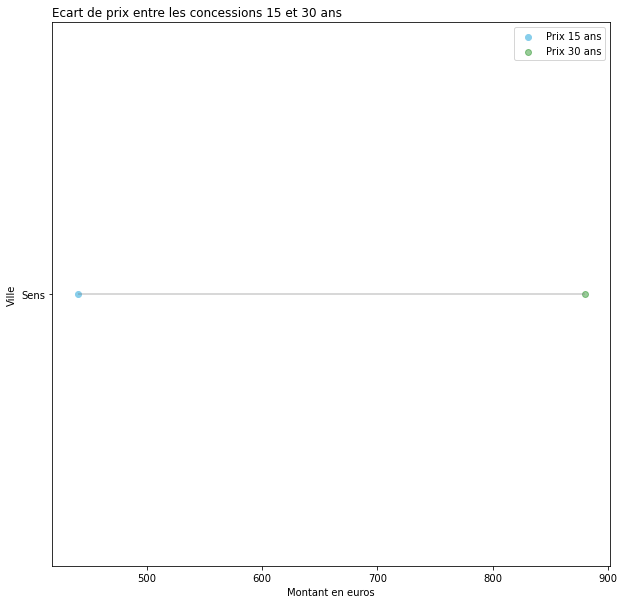

In [24]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.image as mpimg
rcParams['figure.figsize'] = 10, 10

# Reorder it following the values of the first value:
price_cim_col_final_chart = price_cim_col_final_chart.sort_values(by='col_mix')
my_range=range(1,len(price_cim_col_final_chart.index)+1)

plt.hlines(y=my_range, xmin=price_cim_col_final_chart['Prix 15 ans'], 
           xmax=price_cim_col_final_chart['Prix 30 ans'], 
           color='grey', alpha=0.4)
# The horizontal plot is made using the hline function
plt.scatter(price_cim_col_final_chart['Prix 15 ans'], my_range, color='skyblue', alpha=1, label='Prix 15 ans')
plt.scatter(price_cim_col_final_chart['Prix 30 ans'], my_range, color='green', alpha=0.4 , label='Prix 30 ans')
plt.legend()

# Add title and axis names
plt.yticks(my_range, price_cim_col_final_chart['Ville'])
plt.title("Ecart de prix entre les concessions 15 et 30 ans", loc='left')
plt.xlabel('Montant en euros')

plt.ylabel('Ville')


#=arr_lena = mpimg.imread('~/icloud/Documents/WorkspacePython/DATA/SQL/pierre_tombale.png')

# Show the graph
plt.show()